<a href="https://colab.research.google.com/github/KajariBhaumik/BasketballShootingAnalysis/blob/main/3_prediction_scoring_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

!pip install ultralytics
!pip install albumentations==1.4
from ultralytics import YOLO

from IPython import display
display.clear_output()

# import streamlit as st
# import tempfile

In [3]:
HOME = "drive/My Drive/Basketball_computer_vision/datasets/Basketball_Project-Final"
yolo_weights = os.path.join(HOME, "YOLO_train_Final", "weights", "best.pt")
model = YOLO(yolo_weights)


output_path = '/content/drive/My Drive/Basketball_computer_vision/datasets/Basketball_Project-Final/scored_output'

In [13]:
# Helper Functions
def first_frame_with_hand_multi_shot(model, video_path, min_gap_seconds):
    """
    Detect the first frames where the ball is released in a multi-shot video.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Error: Unable to open video file.")

    frame_number = 0
    hand_detected_frames = []
    hand_detected_frames_images = []

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        raise ValueError("Error: Unable to retrieve video frame rate.")
    min_frame_gap = int(fps * min_gap_seconds)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1

        # print(f"processing frame number = {frame_number}")

        # Detect hands in the frame
        results = model(frame, classes=1, verbose=False)
        hand_detected_in_frame = False
        for result in results:
            for box in result.boxes:
                class_id = int(box.cls[0])
                if class_id == 1:  # Hand detected
                    hand_detected_in_frame = True
                    break
            if hand_detected_in_frame:
                break

        if hand_detected_in_frame:
            # Ensure sufficient time gap before adding a new detection
            if (not hand_detected_frames or
                frame_number - hand_detected_frames[-1] > min_frame_gap):
                hand_detected_frames.append(frame_number)

                # Draw bounding box on the frame
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Save the frame with the bounding box
                hand_detected_frames_images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()

    if not hand_detected_frames:
        raise ValueError("No hand detected in the video.")
    else:
        print(f"total {len(hand_detected_frames)} shots detected")

    return hand_detected_frames, hand_detected_frames_images


def calculate_unit_vectors(radius, center_x, center_y, markers):
    """
    Calculate unit vectors for markers relative to the center of the ball.
    """
    unit_vectors = []
    for (x, y) in markers:
        x_local = (x - center_x) / radius
        y_local = (y - center_y) / radius
        z = np.sqrt(max(0, 1 - x_local**2 - y_local**2))
        unit_vectors.append((x_local, y_local, z))
    return unit_vectors

def detect_blobs(frame, detector):
    """
    Detect blobs (e.g., white dots on the basketball).
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
    keypoints = detector.detect(255 - enhanced_gray)
    return np.array([kp.pt for kp in keypoints]), keypoints

def process_basketball_frame(video_path, frame_number):
    """
    Crop and preprocess a specific frame to detect the basketball and prepare it for blob detection.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)

    ret, frame = cap.read()
    if not ret:
        return None, None, None

    results = model(frame, classes=0, verbose=False)  # Detect basketball

    for result in results:
        for box in result.boxes:
            ball_box = [int(i) for i in box.xyxy[0].tolist()]
            xmin, ymin, xmax, ymax = ball_box

            # Crop and zoom the frame around the basketball
            cropped_frame = frame[ymin:ymax, xmin:xmax]
            zoom_factor = 3.0
            zoomed_frame = cv2.resize(cropped_frame, (0, 0), fx=zoom_factor, fy=zoom_factor)

            center_x, center_y = zoomed_frame.shape[1] // 2, zoomed_frame.shape[0] // 2
            radius = min(zoomed_frame.shape[1], zoomed_frame.shape[0]) // 2

            # Mask and enhance detection
            mask = np.zeros_like(zoomed_frame)
            cv2.circle(mask, (center_x, center_y), radius, (255, 255, 255), thickness=-1)
            masked_frame = cv2.bitwise_and(zoomed_frame, mask)

            return masked_frame, center_x, center_y, radius

    cap.release()
    return None, None, None, None

def spin_axis_calc(video_path, frame_number, hand, iteration_limit=20, cutoff_distance=26):
    """
    Calculate the spin axis of the basketball using consecutive frames.
    """
    cap = cv2.VideoCapture(video_path)

    spin_axis_found = False

    # Initialize blob detector
    detector = cv2.SimpleBlobDetector_create()

    # Blob detector setup
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 40
    params.maxArea = 140
    params.filterByCircularity = True
    params.minCircularity = 0.7
    detector = cv2.SimpleBlobDetector_create(params)


    for _ in range(iteration_limit):
        frame1, center_x1, center_y1, radius1 = process_basketball_frame(video_path, frame_number)
        frame2, center_x2, center_y2, radius2 = process_basketball_frame(video_path, frame_number + 1)

        if frame1 is None or frame2 is None:
            frame_number += 1
            continue

        # Detect blobs in both frames
        markers1, keypoints1 = detect_blobs(frame1, detector)
        markers2, keypoints2 = detect_blobs(frame2, detector)

        output_frame1 = cv2.drawKeypoints(frame1, keypoints1, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        output_frame2 = cv2.drawKeypoints(frame2, keypoints2, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        if len(markers1) == 0 or len(markers2) == 0:
            frame_number += 1
            continue

        # Calculate unit vectors
        unit_vectors1 = calculate_unit_vectors(radius1, center_x1, center_y1, markers1)
        unit_vectors2 = calculate_unit_vectors(radius2, center_x2, center_y2, markers2)

        # Match points between frames based on the hand argument
        matched_points = []
        matched_index = []
        for idx1, (marker1, uv1) in enumerate(zip(markers1, unit_vectors1)):
            valid_indices = [idx2 for idx2, marker2 in enumerate(markers2)
                             if (hand == "LEFT" and marker2[0] < marker1[0]) or
                                (hand == "RIGHT" and marker2[0] > marker1[0])]
            for idx2 in valid_indices:
                distance = np.linalg.norm(marker1 - markers2[idx2])
                if distance < cutoff_distance:
                    matched_points.append((marker1, markers2[idx2]))
                    matched_index.append((idx1, idx2))

        if len(matched_points) < 3:
            frame_number += 1
            continue

        # Plot the frames with detected blobs
        print("=" * 10, "Calculating Spin Axis", "=" * 10)
        fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
        axs[0].imshow(cv2.cvtColor(output_frame1, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f'Frame {frame_number} with Detected Dots')

        axs[1].imshow(cv2.cvtColor(output_frame2, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f'Frame {frame_number+1} with Detected Dots')

        axs[2].scatter(markers1[:, 0], markers1[:, 1], color='blue', label=f'Frame {frame_number}')
        axs[2].scatter(markers2[:, 0], markers2[:, 1], color='red', label=f'Frame {frame_number+1}')
        for (pt1, pt2) in matched_points:
            axs[2].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g--')
        axs[2].invert_yaxis()
        plt.show()

        # Calculate rotation matrix using matched points
        B = sum(np.outer(unit_vectors1[idx1], unit_vectors2[idx2]) for idx1, idx2 in matched_index)
        S = B + B.T
        sigma = np.trace(B)
        Z = np.array([B[1, 2] - B[2, 1], B[2, 0] - B[0, 2], B[0, 1] - B[1, 0]])

        K = np.block([
            [np.array([[sigma]]), Z.reshape(1, -1)],
            [Z.reshape(-1, 1), S - sigma * np.eye(3)]
        ])

        eigvals, eigvecs = np.linalg.eig(K)
        q = eigvecs[:, np.argmax(eigvals)]

        # Calculate spin axis
        q0, q1, q2, q3 = q
        R = np.array([
            [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
            [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
            [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
        ])
        spin_axis = np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
        spin_axis /= np.linalg.norm(spin_axis)
        ex, ey, ez = spin_axis
        theta_spin = np.arccos(abs(ex)) * (180 / np.pi)

        # Display results
        print(f"Spin axis for frame pair {frame_number}-{frame_number+1}: ex = {ex:.4f}, ey = {ey:.4f}, ez = {ez:.4f}")
        print(f"Misalignment Angle (theta_spin) for frame pair {frame_number}-{frame_number+1}: {theta_spin:.2f} degrees")
        spin_axis_found = True

        return spin_axis

    if not spin_axis_found:
        print("Spin Axis Calculation FAILED!")
    return None

total 1 shots detected


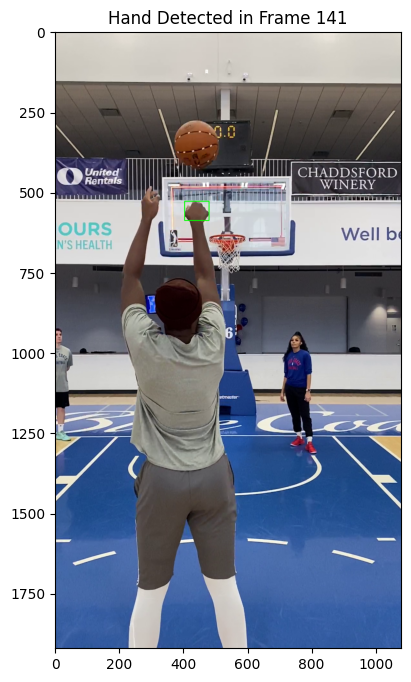

========== Calculating Spin Axis ==========


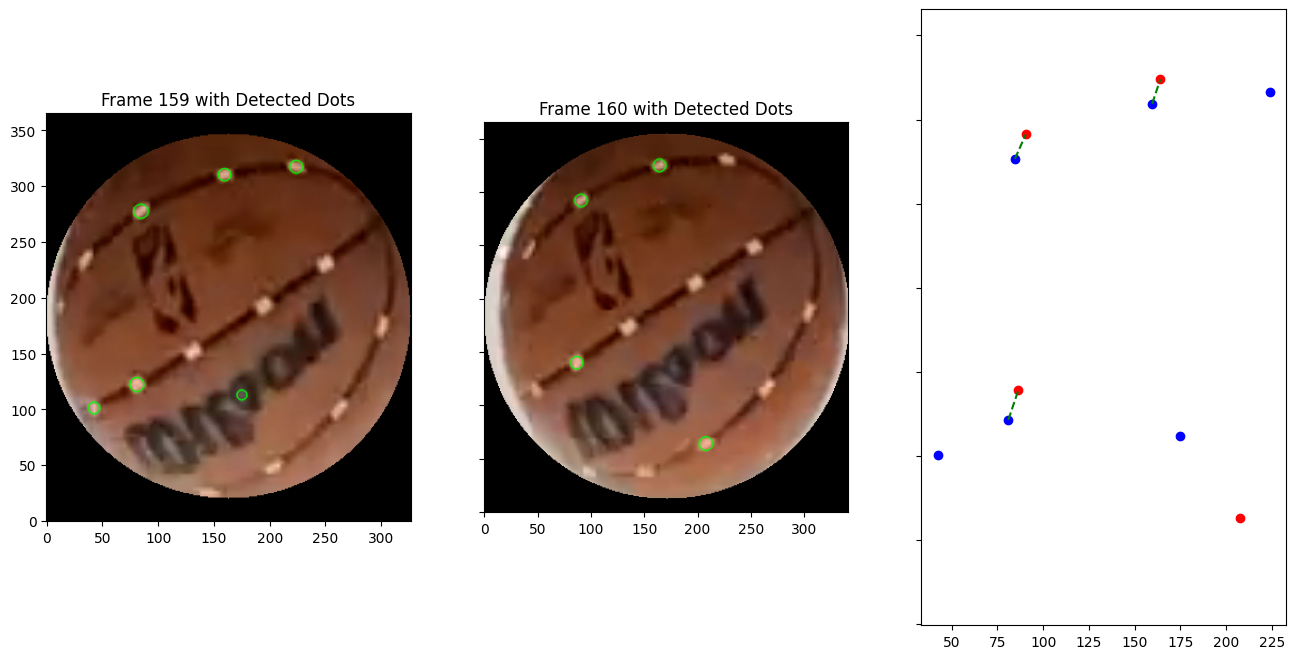

Spin axis for frame pair 159-160: ex = -0.9928, ey = 0.1130, ez = 0.0411
Misalignment Angle (theta_spin) for frame pair 159-160: 6.90 degrees


In [14]:
video_path = '/content/drive/My Drive/Basketball_computer_vision/SpinVideos/Copy of 01232023101323.MOV'
min_gap_seconds = 3
hand_detected_frames, hand_detected_frames_images = first_frame_with_hand_multi_shot(model, video_path, min_gap_seconds)

for frame_number, frame_image in zip(hand_detected_frames, hand_detected_frames_images):
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_image)
    plt.title(f"Hand Detected in Frame {frame_number}")
    plt.show()
    spin_axis_calc(video_path, frame_number, hand="RIGHT")

In [ ]:
video_path = '/content/drive/My Drive/Basketball_computer_vision/multiple_shots/11062024122324834.MOV'
min_gap_seconds = 3
hand_detected_frames, hand_detected_frames_images = first_frame_with_hand_multi_shot(model, video_path, min_gap_seconds)

for frame_number, frame_image in zip(hand_detected_frames, hand_detected_frames_images):
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_image)
    plt.title(f"Hand Detected in Frame {frame_number}")
    plt.show()
    spin_axis_calc(video_path, frame_number, hand="RIGHT")

In [12]:
nic_claxton_vdo = '/content/drive/My Drive/Basketball_computer_vision/Nic Claxton/'
ext='mov'

for vdo_file in os.listdir(nic_claxton_vdo):
    print(vdo_file)
    print("="*20)

    if vdo_file[-4:] != '.mov':
        continue
    else:
      try:
          vdo_file = vdo_file[:-4]
          min_gap_seconds = 3

          vdo_path = os.path.join(nic_claxton_vdo, f"{vdo_file}.{ext}")

          shot_frames, imgs = first_frame_with_hand_multi_shot(model, vdo_path, min_gap_seconds, ext = ext)

          # print("Showing the first frames ...")
          # for img in imgs:
          #     plt.imshow(img)
          #     plt.show()

          for f in shot_frames:
              spin_axis_calc(vdo_path, f, hand="LEFT", cutoff_distance = 70, ext='mov', show_img=False)

      except:
          print(f"could not process {vdo_file} *************")

Copy of 11202024094049379.mov
could not process Copy of 11202024094049379 *************
Copy of 11202024094057551.mov
could not process Copy of 11202024094057551 *************
Copy of Nic CLaxton Nov23.png
Copy of output.txt
Copy of 11202024094108528.mov
could not process Copy of 11202024094108528 *************
Copy of 11202024094123924.mov
could not process Copy of 11202024094123924 *************
Copy of 11202024094116569.mov
could not process Copy of 11202024094116569 *************
Copy of 11202024094041657.mov
could not process Copy of 11202024094041657 *************
Copy of 11202024094133181.mov
could not process Copy of 11202024094133181 *************
Copy of 11202024094032285.mov
could not process Copy of 11202024094032285 *************
Copy of 11202024094023594.mov
could not process Copy of 11202024094023594 *************
Copy of 11202024094016078.mov
could not process Copy of 11202024094016078 *************


Hand detected in frame 227


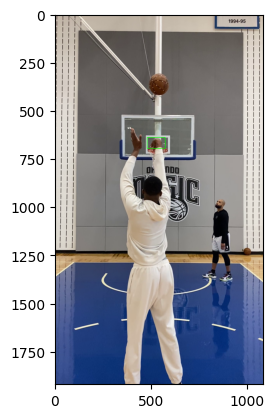

processing frame = 227


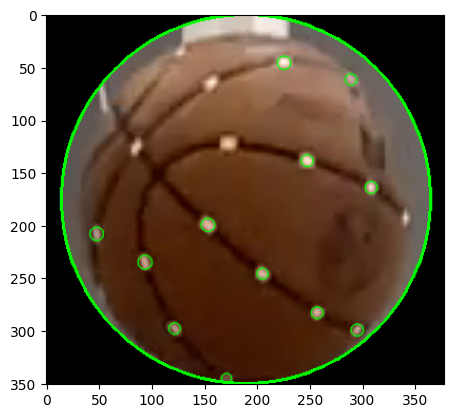

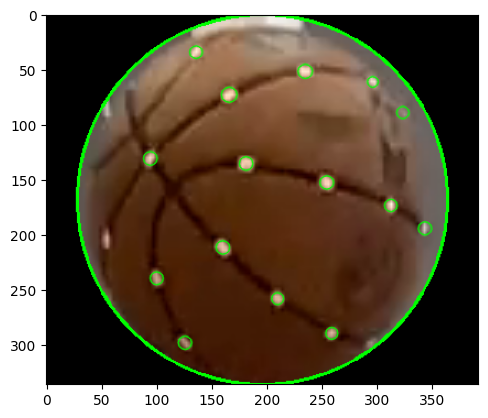

========== Calculating Spin Axis ==========


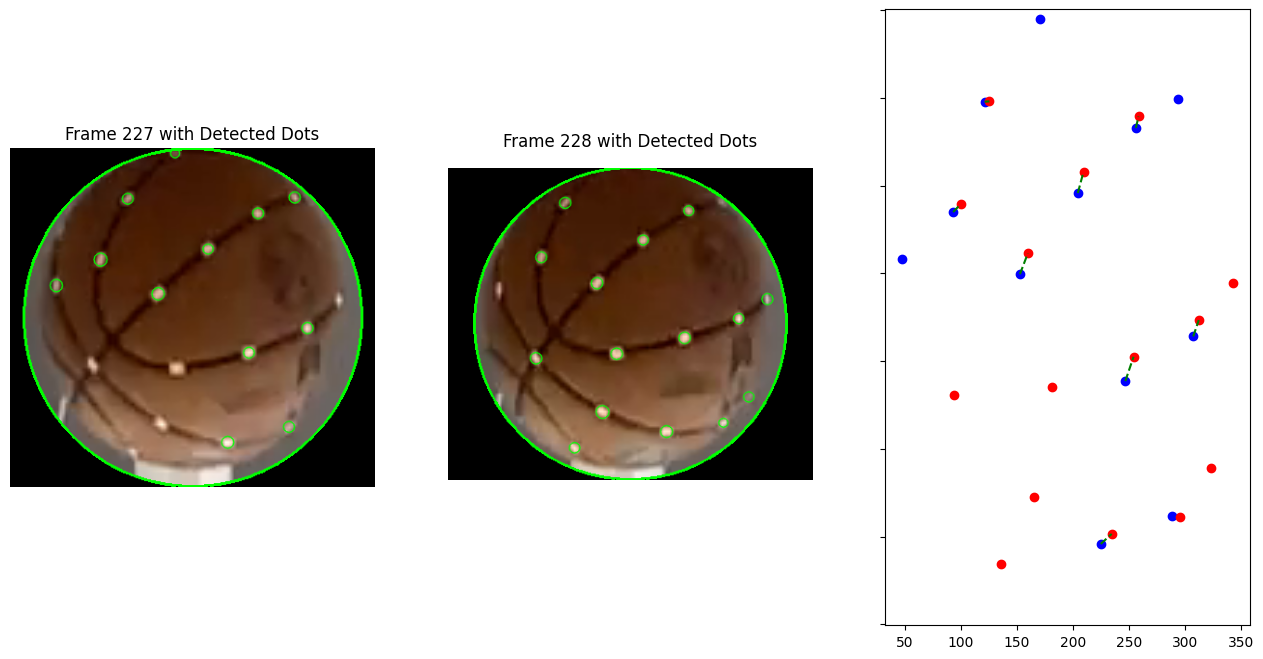

Spin axis for frame pair 227-228: ex = -0.9807, ey = 0.0319, ez = 0.1928
Misalignment Angle (theta_spin) for frame pair 227-228: 11.27 degrees


(array([   -0.98072,     0.03194,     0.19281]), 11.270496060046717)

In [ ]:

cutoff_distance = 26
# Blob detector setup
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 40
params.maxArea = 140
params.filterByCircularity = True
params.minCircularity = 0.7
detector = cv2.SimpleBlobDetector_create(params)

input_path = '/content/drive/My Drive/Basketball_computer_vision/SpinVideos/'
file = "Copy of 01262023134909"

first_frame, first_img = first_frame_with_hand(model, input_path, file, ext='MOV', show_img = True)
plt.imshow(first_img)
plt.show()

spin_axis_calc(first_frame, hand="RIGHT", cutoff_distance = 26)

Hand detected in frame 117


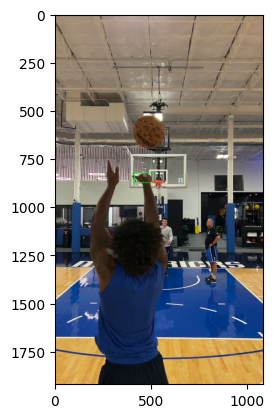

processing frame = 117


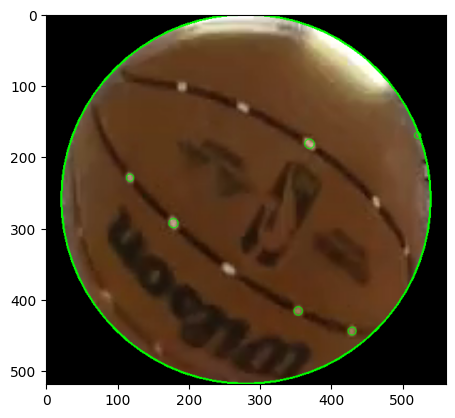

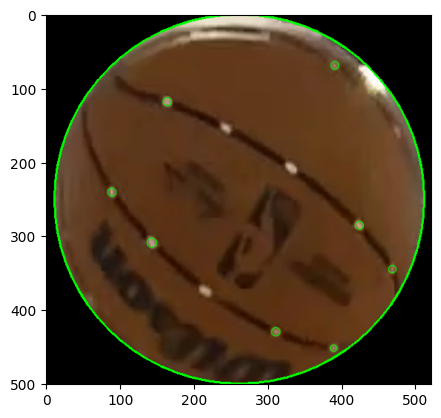

processing frame = 118


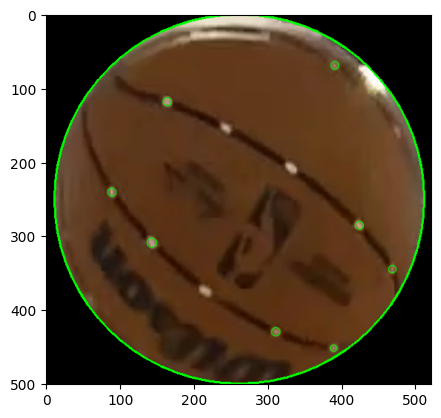

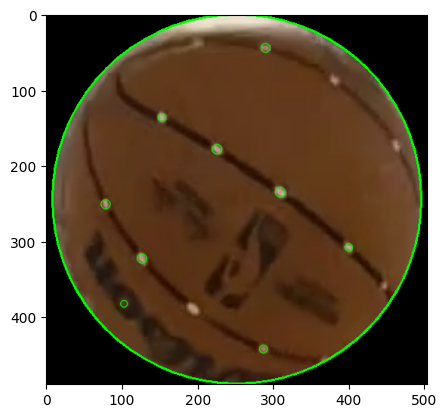

========== Calculating Spin Axis ==========


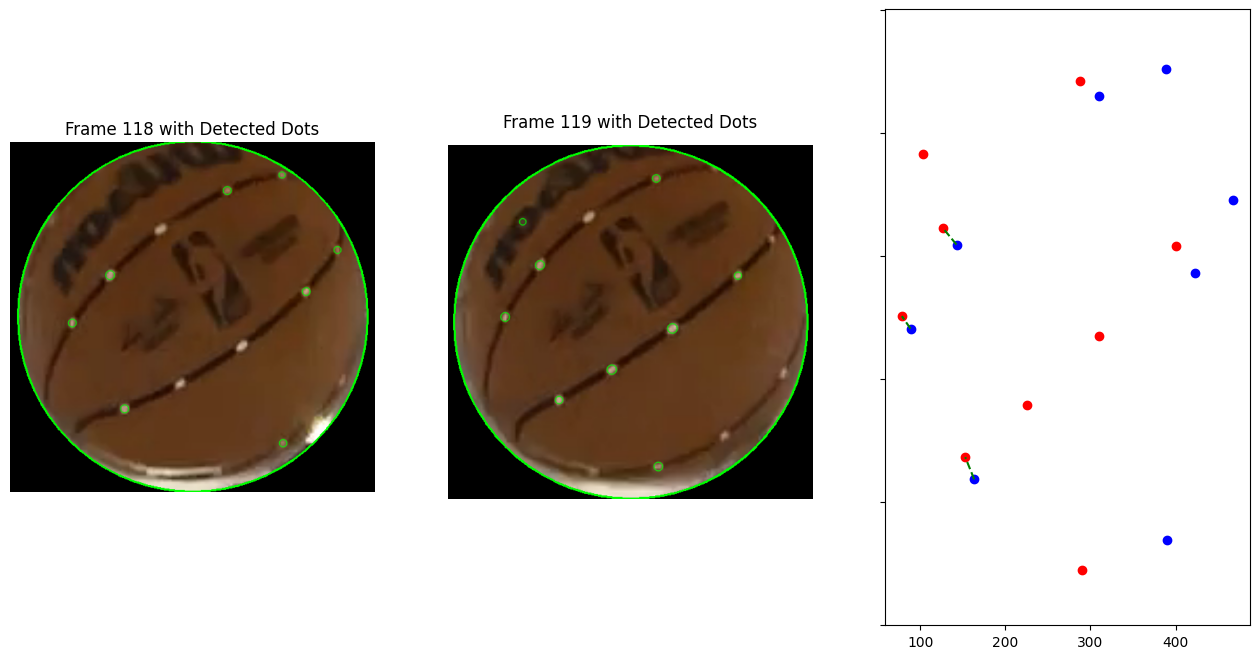

Spin axis for frame pair 118-119: ex = -0.9340, ey = -0.2714, ez = 0.2324
Misalignment Angle (theta_spin) for frame pair 118-119: 20.93 degrees


(array([     -0.934,    -0.27137,     0.23238]), 20.93244510374893)

In [ ]:

cutoff_distance = 26
# Blob detector setup
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 40
params.maxArea = 140
params.filterByCircularity = True
params.minCircularity = 0.7
detector = cv2.SimpleBlobDetector_create(params)

input_path = '/content/drive/My Drive/Basketball_computer_vision/SpinVideos/'
file = "Copy of 09062023083524"

first_frame, first_img = first_frame_with_hand(model, input_path, file, ext='MOV', show_img = True)
plt.imshow(first_img)
plt.show()

spin_axis_calc(first_frame, hand="LEFT", cutoff_distance = 26)

In [ ]:
first_frame_with_hand(model, input_path,'Copy of 01232023101323')

Hand detected in frame 141


141

Copy of 09072023125836.MOV
Hand detected in frame 154
Copy of 01232023124429.MOV
Hand detected in frame 123
Copy of 01232023102938.MOV
Hand detected in frame 63
Copy of 01262023142118.MOV
Hand detected in frame 99
Copy of Facu CS3 3.MOV
Hand detected in frame 25


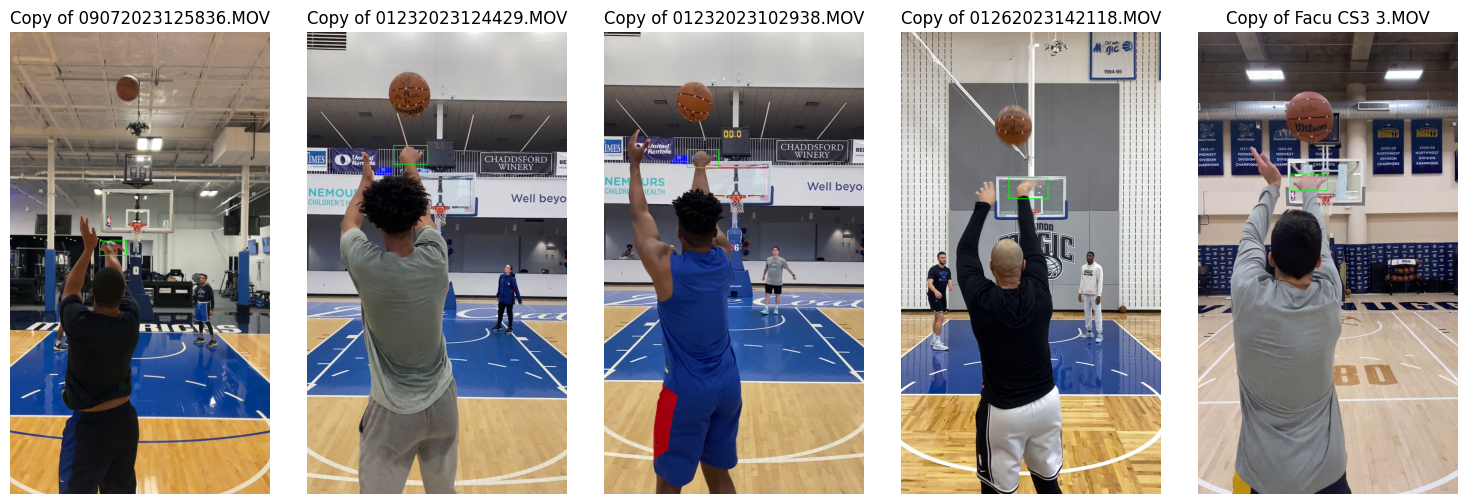

In [ ]:
import random

all_vdos = os.listdir(input_path)
sample_vdos = random.sample(all_vdos, 5)



detected_frames = []
for file in sample_vdos:
    print(file)
    frame_number, frame_image = first_frame_with_hand(model, input_path, file[:-4], show_img=True)
    if frame_image is not None:
        detected_frames.append((file, frame_image))

# Display all frames side by side
if detected_frames:
    num_frames = len(detected_frames)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    if num_frames == 1:
        axes = [axes]  # Ensure axes is iterable for a single frame
    for ax, (file, frame_image) in zip(axes, detected_frames):
        ax.imshow(frame_image)
        ax.set_title(f"{file}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
len(all_vdos)

43

# LONG VIDEOS

In [ ]:
def first_frame_with_hand_multi_shot(model, input_path, file):
    input_file = os.path.join(input_path, f"{file}.MOV")
    cap = cv2.VideoCapture(input_file)

    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return None

    frame_number = 0
    hand_detected_frames = []
    hand_detected_in_current_shot = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1

        results = model(frame, classes=1, verbose=False)

        hand_detected_in_frame = False
        for result in results:
            for box in result.boxes:
                class_id = int(box.cls[0])
                if class_id == 1:  # Hand detected
                    hand_detected_in_frame = True
                    break  # Exit inner loop if hand is found
            if hand_detected_in_frame:
                break  # Exit outer loop if hand is found

        if hand_detected_in_frame and not hand_detected_in_current_shot:
            hand_detected_frames.append(frame_number)
            hand_detected_in_current_shot = True
            print(f"Hand detected in frame {frame_number}")

            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Draw bounding box on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Display the frame with the bounding box
            plt.figure(figsize=(10, 8))  # Set figure size
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Hand Detected in Frame {frame_number}")
            plt.show()

        # Assume hand disappears after a certain number of frames without detection
        if not hand_detected_in_frame and hand_detected_in_current_shot:
            hand_detected_in_current_shot = False

    cap.release()

    if not hand_detected_frames:
        print("Hand not detected in any frame.")

    return hand_detected_frames  # Return a list of frames

Hand detected in frame 98


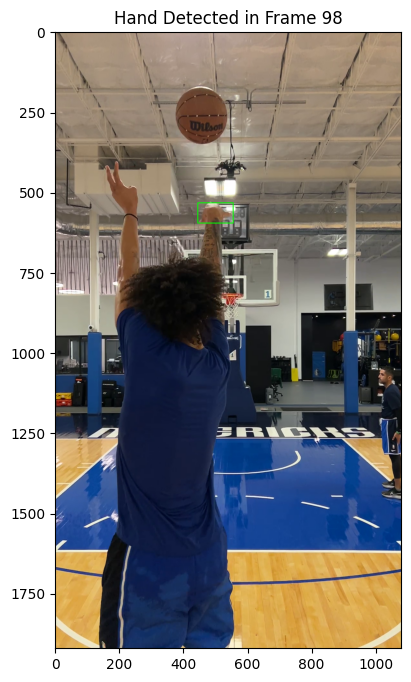

Hand detected in frame 102


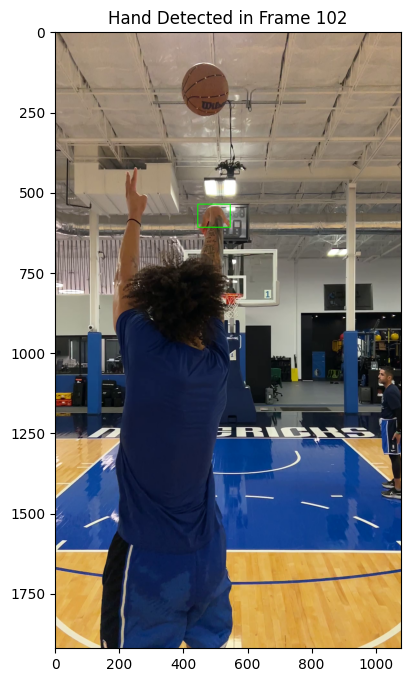

Hand detected in frame 265


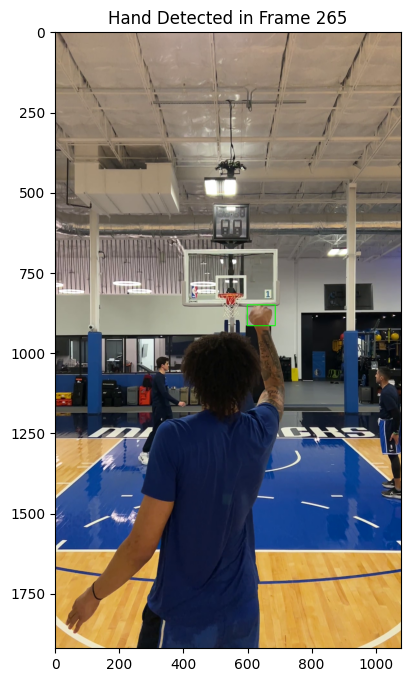

Hand detected in frame 270


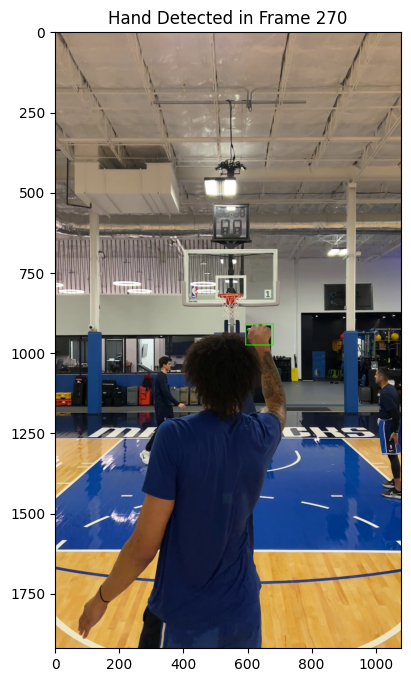

[98, 102, 265, 270]

In [ ]:
first_frame_with_hand_multi_shot(model, input_path,'Copy of 09072023115849')